In [1]:
!nvidia-smi

Thu Sep 30 10:08:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  RTX A6000           On   | 00000000:09:00.0 Off |                  Off |
| 69%   86C    P2   286W / 300W |  17092MiB / 48682MiB |     98%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import argparse
import os
import shutil
import time
import pandas as pd
import network.resnet_orig as resnet
import matplotlib.pyplot as plt

import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

DATA_DIR = "train"

print_freq = 50

K = 4

In [3]:
train_df = pd.read_csv("trainLabels.csv")
train_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
train_df.head()

,id,label,label_enc
0,1,frog,6
1,2,truck,9
2,3,truck,9
3,4,deer,4
4,5,automobile,1


In [5]:
# 5-flod
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


# prepare dataset

In [6]:
mixup = False

class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
        
        # Mixup part
        """
        rd = np.random.rand()
        label2 = label
        gamma = np.array(np.ones(1)).astype(np.float32)[0]
        if mixup and rd < 0.3 and self.transform is not None:
            mix_idx = np.random.random_integers(0, len(self.df))
            row2 = self.df.iloc[mix_idx]
            img_id2 = row2.image_id
            tiff_file = os.path.join(image_folder, f'{img_id2}.png')
            images2 = cv2.imread(tiff_file)
            
            if self.transform is not None:
                images2 = self.transform(image=images2)['image']
            
            # blend image
            gamma = np.array(np.random.beta(1,1)).astype(np.float32)
            images = ((images*gamma + images2*(1-gamma))).astype(np.uint8)
            # blend labels
            label2 = row2.label_enc
        """
              
        images = images.astype(np.float32)
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [7]:
import albumentations as A
import albumentations

imsize = 32
transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=30,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])
transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


show imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

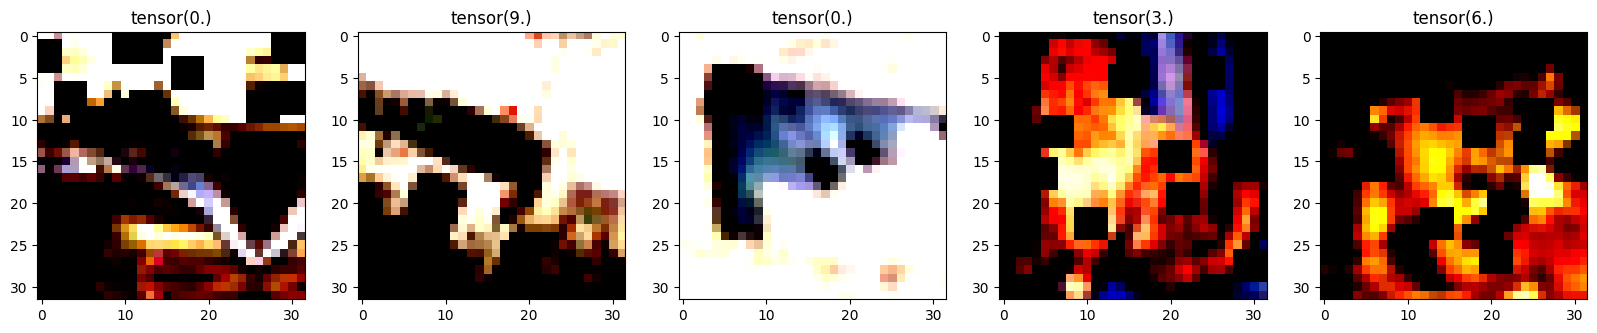

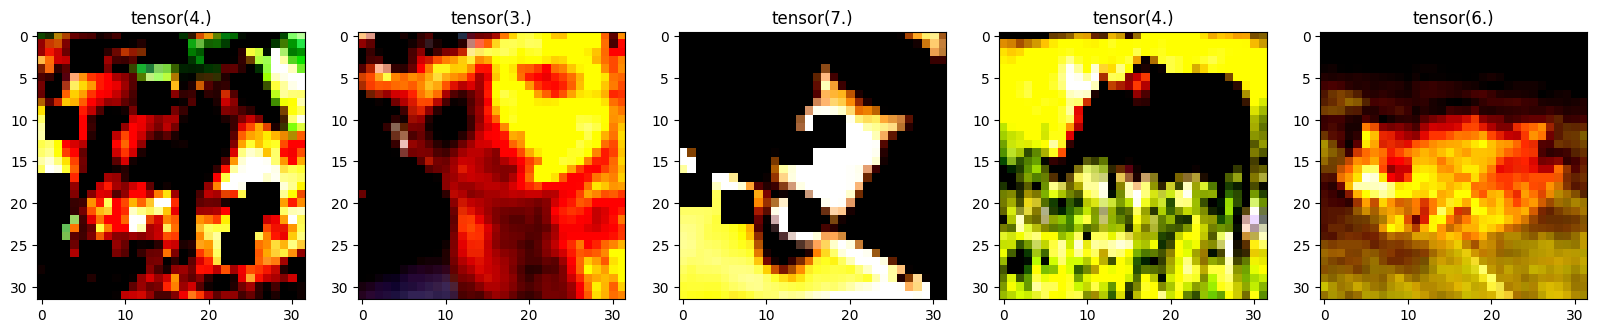

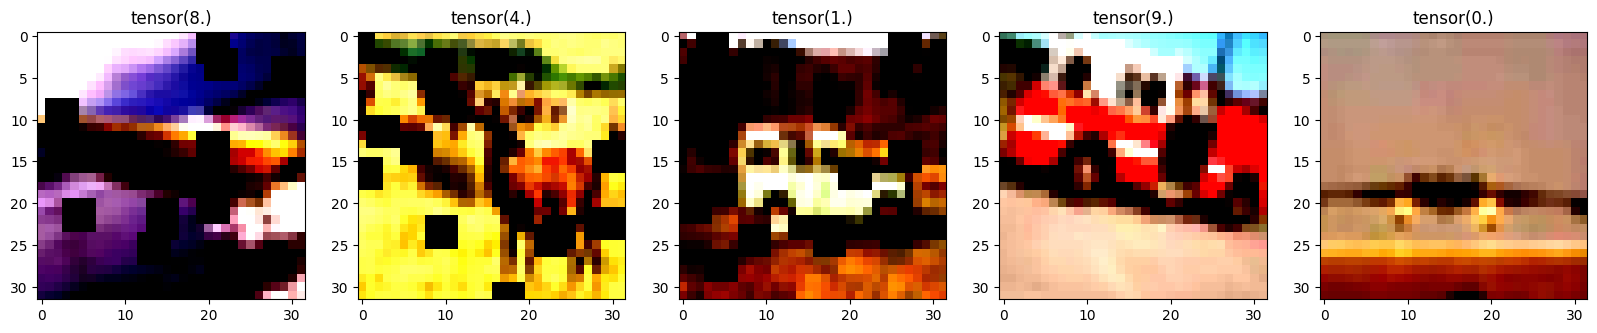

In [8]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

# Trainer

In [17]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.0002
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.long().cuda()
        input_var = input.cuda()
        target_var = target

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

# Train loop

In [18]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=512, shuffle=True,
        num_workers=2, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2048, shuffle=False,
    num_workers=2, pin_memory=True)

# Add after conv2d

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from module import ActFn, Linear, Conv2d
from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, k=8, expansion=1, snr=0.1):
        super(BasicBlock, self).__init__()
        self.k = k
        self.expansion = expansion
        self.conv1 = Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False, bitwidth = k)
        self.bn1 = nn.BatchNorm2d(planes)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.conv2 = Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False, bitwidth = k)
        self.bn2 = nn.BatchNorm2d(planes)
        self.alpha2 = nn.Parameter(torch.tensor(10.))
        self.ActFn = ActFn.apply
        self.snr = snr

        if stride != 1 or in_planes != planes:
              # change output dimention if stride!=1 or planes differ.
              self.shortcut = nn.Sequential(
                    Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion * planes)
              )
        else: # nothing done if stride or inplanes do not differ. simply add x
          self.shortcut = nn.Sequential()

    def forward(self, x):
        # conv1
        x2 = self.conv1(x)
        rang1 = x2.max() - x2.min()
        print("alpha:{}, std:{}, range:{}".format(self.alpha1, x2.std(), rang1))
        x2 += (torch.randn(x2.size()).cuda()-0.)*self.snr*x2.std() # scale by x2 divergence
        out = self.ActFn(self.bn1(x2), self.alpha1, self.k)
        
        # conv2+shortcut
        out = self.conv2(out)
        rang2 = out.max() - out.min()
        print("alpha:{}, std:{}, range:{}".format(self.alpha2, out.std(), rang2))
        out += (torch.randn(out.size()).cuda()-0.)*self.snr*out.std()
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.ActFn(out, self.alpha2, self.k)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, K=8, snr=0.1):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.k = K
        self.snr = snr

        # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False, bitwidth = 8)
        self.bn1 = nn.BatchNorm2d(64)
        self.alpha1 = nn.Parameter(torch.tensor(10.))
        self.ActFn = ActFn.apply
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, expansion=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, expansion=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, expansion=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, expansion=1)
        # self.linear = nn.Linear(64, num_classes)
        self.linear = Linear(512, num_classes, bitwidth = 8)
        self.apply(_weights_init)       

    def _make_layer(self, block, planes, num_blocks, stride, expansion):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.k, expansion, self.snr))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        # out = F.relu(self.bn1(self.conv1(x)))
        out = self.ActFn(self.bn1(self.conv1(x)), self.alpha1, self.k)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(k=8, snr=0.1):
    print("bit width:", k)
    print("snr:", snr)
    return ResNet(BasicBlock, [2, 2, 2, 2], K=k, snr=snr)

def resnet34(k=8, snr=0, inference=False, conv1_noise=True, linear_noise=True):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 4, 6, 3], K=k, snr=snr)

def resnet50(k=8, snr=0, inference=False, conv1_noise=True, linear_noise=True):
    print("bit width:", k)
    return ResNet(BasicBlock, [3, 4, 6, 3], K=k, snr=snr)

In [22]:
results = []
criterion = nn.CrossEntropyLoss().cuda()

for K in range(3,8):
    top1 = []
    for snr in [0, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5]:
        model = resnet20(K, snr=snr)
        model = model.cuda().eval()
        checkpoint = torch.load("models/resnet20_paper_quant{}.pth".format(K))
        model.load_state_dict(checkpoint)

        # validate
        prec1, valloss = validate(val_loader, model, criterion)
        top1.append(prec1)
    results.append(top1)

bit width: 3
snr: 0
alpha:0.759184718132019, std:1.9810049533843994, range:27.017248153686523
alpha:1.070306420326233, std:1.1535053253173828, range:19.924724578857422
alpha:0.6189409494400024, std:2.843672275543213, range:40.93375778198242
alpha:1.085792064666748, std:1.038840889930725, range:15.006162643432617
alpha:0.6784900426864624, std:2.882931709289551, range:37.581695556640625
alpha:0.969395101070404, std:1.5378105640411377, range:21.974767684936523
alpha:0.6681086421012878, std:2.994020462036133, range:41.70376968383789
alpha:1.0211071968078613, std:0.8530911207199097, range:15.58465576171875
alpha:0.8129854202270508, std:3.2932074069976807, range:44.904563903808594
alpha:1.0435094833374023, std:1.8103505373001099, range:27.541955947875977
alpha:0.6462991237640381, std:2.8281545639038086, range:42.12370300292969
alpha:1.122750163078308, std:0.9243378639221191, range:15.326533317565918
alpha:0.6158198714256287, std:2.983330011367798, range:48.819454193115234
alpha:1.04730331897

KeyboardInterrupt: 

save results

In [ ]:
dicts = []
for i, top1 in enumerate(results):
    dicts.append({"bit":i+3, "top1":top1, "noise":[0, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5]})
dicts

In [ ]:
df = pd.DataFrame(dicts)
df

In [19]:
df.to_csv("results/3-7bit_resnet20_withgaussnoise_afterconv_scalewithstd.csv")